In [28]:
import pandas as pd
import torch
from utils.MLP import MLP
from utils.ANFIS import ANFIS
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.datasets import load_iris
import numpy as np


Model ANFIS jest przeznaczony do regresji, jednak można go użyć także do klasyfikacji traktując zmienne kategoryczne jako liczby całkowite.

# Power plant dataset - regresja

## Opis zbioru danych

Zbiór danych zawiera 9568 wierszy danych zebranych z elektrowni typu Combined Cycle Power Plant (CCPP) na przestrzeni 6 lat (2006-2011), gdy elektrownia pracowała z pełnym obciążeniem. Cechy obejmują godzinne średnie wartości zmiennych środowiskowych: temperatura (T), ciśnienie atmosferyczne (AP), wilgotność względna (RH) oraz próżnia w układzie wydechowym (V), a celem jest przewidywanie netto godzinowej produkcji energii elektrycznej (EP) w elektrowni.

Elektrownia typu CCPP składa się z turbin gazowych, turbin parowych oraz generatorów odzysku ciepła. W CCPP energia elektryczna jest generowana przez turbiny gazowe i parowe, które są połączone w jednym cyklu, a energia jest przekazywana z jednej turbiny do drugiej. Podczas gdy próżnia jest mierzona w układzie wydechowym i ma wpływ na wydajność turbiny parowej, pozostałe trzy zmienne środowiskowe wpływają na wydajność turbiny gazowej.

https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant

In [2]:
print("Loading dataset from powerPlant.csv...")
data = pd.read_csv("data/powerPlant.csv")
data

Loading dataset from powerPlant.csv...


,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43
...,...,...,...,...,...
9563,15.12,48.92,1011.80,72.93,462.59
9564,33.41,77.95,1010.30,59.72,432.90
9565,15.99,43.34,1014.20,78.66,465.96
9566,17.65,59.87,1018.58,94.65,450.93


## Porównanie modeli

Ładujemy dane testowe zapisane w trakcie trenowania modelu

In [3]:
print("Loading test dataset")
data = pd.read_csv("test_datasets/power_plant_test_dataset.csv", header=None)
data

Loading test dataset


,0,1,2,3,4
0,0.818194,1.315638,-0.890864,1.158211,433.75
1,0.519787,1.148779,-0.958303,-0.298312,437.48
2,1.452475,0.976410,0.731042,-2.423066,432.87
3,-0.913368,-0.642600,0.896267,1.025114,466.06
4,-0.487838,-1.195125,0.532097,0.282102,468.49
...,...,...,...,...,...
952,-0.105128,-0.280546,-0.801508,1.245342,446.70
953,1.520721,1.340037,-1.654610,-1.266355,430.82
954,1.322675,0.794596,0.001015,-0.944589,440.10
955,0.588032,1.423467,-0.875690,0.938669,439.39


In [4]:
# Split features and target
X = data.iloc[:, :-1].values  # All columns except the last one as features
y = data.iloc[:, -1].values   # The last column as the target

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

### MLP

In [5]:
model_mlp = MLP(input_dim=X_tensor.shape[1])
# Path to the .pth file
weights_path = "models/power_plant_best_mlp_model.pth"

# Load the state dictionary from the .pth file
state_dict = torch.load(weights_path, weights_only=True)

# Load weights into the model
model_mlp.load_state_dict(state_dict)

# Set the model to evaluation mode 
model_mlp.eval()

# Convert true labels and predictions to numpy arrays
y_test = y_tensor.flatten().numpy()  # Ensure y_test is a 1D array
y_pred = model_mlp(X_tensor).detach().numpy().flatten()  # Flatten predictions 

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error (MSE): 81.95
Mean Absolute Error (MAE): 7.47
R² Score: 0.72


### ANFIS

In [6]:
model_anfis = ANFIS(
    number_of_features=X_tensor.shape[1],
    number_of_membership_functions=3
)
# Path to the .pth file
weights_path = "models/power_plant_best_anfis_model.pth"

# Load the state dictionary from the .pth file
state_dict = torch.load(weights_path, weights_only=True)

# Load weights into the model
model_anfis.load_state_dict(state_dict)

# Set the model to evaluation mode 
model_anfis.eval()

# Convert true labels and predictions to numpy arrays
y_test = y_tensor.flatten().numpy()  # Ensure y_test is a 1D array
y_pred = model_anfis(X_tensor).detach().numpy().flatten()  # Flatten predictions

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error (MSE): 25.34
Mean Absolute Error (MAE): 3.79
R² Score: 0.91


Możemy zwizualizować **funkcje przynależności** dla każdego wejścia

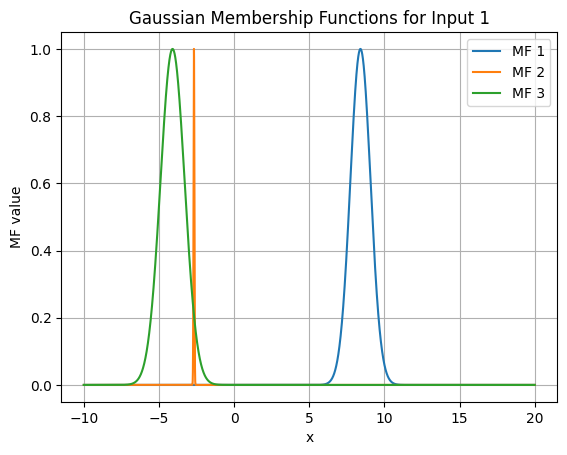

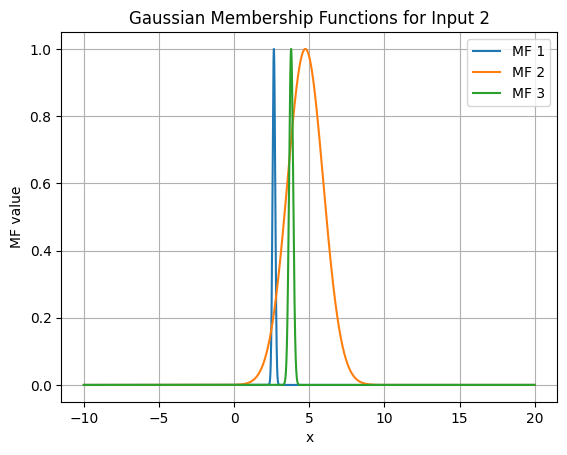

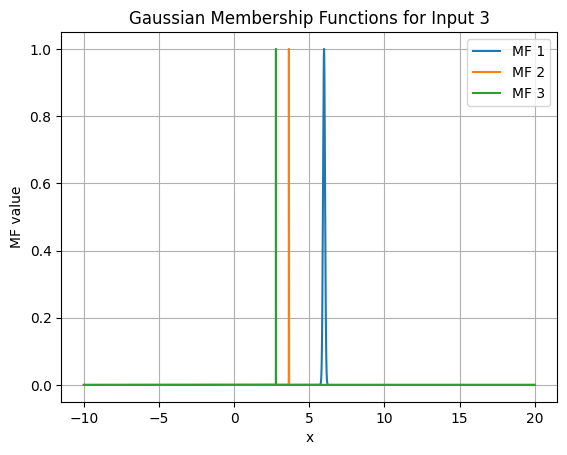

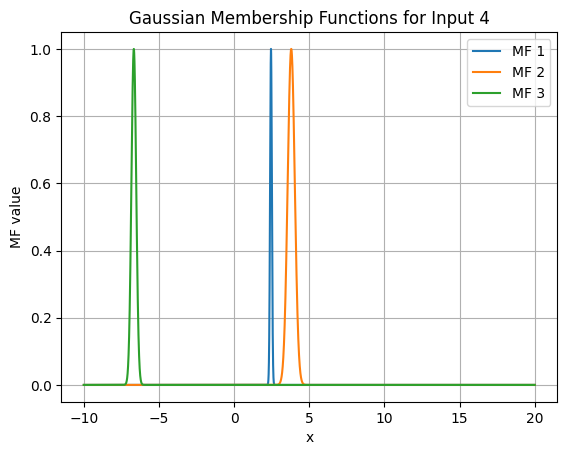

In [7]:
model_anfis.plot_gaussian_with_values(linspace=torch.linspace(-10,20,999999))

### Wniosek
ANFIS w tym przypadku poradził sobie zdecydowanie lepiej. Może to wynikać ze zbyt małej złożoności modelu MLP lub ze złych hiperparametrów podczas treningu. Wszystkie metryki przemawiają na korzyść ANFIS. MSE oraz MAE są niższe. Natomiast R^2 jest wyższy i bliski 1. 

# Abalone - regresja

## Opis zbioru danych

Abalone to powszechna nazwa dla grupy  ślimaków morskich, które można znaleźć wzdłuż wybrzeży na całym świecie. Wykorzystywane są jako przysmak w kuchniach, a ich pozostałe muszle, dzięki opalizującemu połyskowi, przekształcane są w biżuterię. Ze względu na wysokie zapotrzebowanie i wartość ekonomiczną, często hoduje się je na farmach. W związku z tym istnieje potrzeba przewidywania wieku abalone na podstawie pomiarów fizycznych. Tradycyjną metodą określania wieku jest przecięcie muszli przez stożek, jej barwienie, a następnie liczenie liczby pierścieni pod mikroskopem – proces żmudny i czasochłonny.

Dane dotyczące abalone składają się z następujących zmiennych:

Sex: Zmienna nominalna określająca płeć abalone, gdzie:

"M" oznacza osobnika męskiego,
"F" oznacza osobnika żeńskiego,
"I" odnosi się do młodych osobników (infantów).
Length (Długość): Zmienna ciągła, mierzona w milimetrach, reprezentująca najdłuższy wymiar muszli abalone.

Diameter (Średnica): Zmienna ciągła, mierzona w milimetrach, będąca wymiarem prostopadłym do długości muszli.

Height (Wysokość): Zmienna ciągła, mierzona w milimetrach, która uwzględnia mięso wewnątrz muszli.

Whole weight (Waga całkowita): Zmienna ciągła, mierzona w gramach, oznaczająca całkowitą wagę abalone, wliczając muszlę i zawartość.

Shucked weight (Waga mięsa): Zmienna ciągła, mierzona w gramach, określająca wagę samego mięsa po oddzieleniu od muszli.

Viscera weight (Waga wnętrzności): Zmienna ciągła, mierzona w gramach, oznaczająca wagę wnętrzności (po krwawieniu).

Shell weight (Waga muszli): Zmienna ciągła, mierzona w gramach, określająca wagę muszli po jej wysuszeniu.

Rings (Pierścienie): Zmienna całkowita, reprezentująca liczbę pierścieni na muszli. Do określenia wieku abalone należy dodać wartość 1,5 do liczby pierścieni (wiek w latach).

Te dane umożliwiają analizę cech fizycznych abalone oraz przewidywanie ich wieku na podstawie pomiarów, co jest istotne dla hodowli i zarządzania populacjami tego gatunku.

https://archive.ics.uci.edu/dataset/1/abalone

In [8]:
print("Loading dataset from abalone.data...")
data = pd.read_csv("data/abalone.data", header=None)
data

Loading dataset from abalone.data...


,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


## Porównanie modeli
Ładujemy dane testowe zapisane w trakcie trenowania modelu

In [9]:
print("Loading test dataset")
data = pd.read_csv("test_datasets/abalone_test_dataset.csv", header=None)
data

Loading test dataset


,0,1,2,3,4,5,6,7,8,9
0,-0.680846,-0.761200,1.169063,1.073106,1.053355,1.030334,0.884810,1.018448,1.412802,11
1,-0.680846,-0.761200,0.287541,0.312006,0.350020,-0.394253,-0.117593,-0.047431,0.033316,8
2,-0.680846,-0.761200,0.371496,0.565706,0.467243,0.120633,-0.214021,0.693652,0.162307,10
3,-0.680846,1.313716,0.119632,0.007566,-0.236092,-0.558081,-0.559368,-0.687874,-0.468315,7
4,1.468761,-0.761200,-0.216185,-0.195394,-0.353314,-0.511273,-0.305964,-0.454570,-0.572224,8
...,...,...,...,...,...,...,...,...,...,...
413,1.468761,-0.761200,-0.468049,-0.398355,-0.470537,-0.740224,-0.797074,-0.697023,-0.611638,12
414,-0.680846,1.313716,0.455450,0.514966,0.232798,0.370954,0.577586,0.359707,0.176639,9
415,-0.680846,1.313716,0.917200,1.022366,1.053355,0.964193,0.815292,1.247178,0.979249,8
416,-0.680846,1.313716,-0.552003,-0.347615,-0.001647,-0.658819,-0.763437,-0.706173,-0.253330,9


In [10]:
# Split features and target
X = data.iloc[:, :-1].values  # All columns except the last one as features
y = data.iloc[:, -1].values   # The last column as the target

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

### MLP

In [11]:
model_mlp = MLP(input_dim=X_tensor.shape[1])
# Path to the .pth file
weights_path = "models/abalone_best_mlp_model.pth"

# Load the state dictionary from the .pth file
state_dict = torch.load(weights_path, weights_only=True)

# Load weights into the model
model_mlp.load_state_dict(state_dict)

# Set the model to evaluation mode 
model_mlp.eval()

# Convert true labels and predictions to numpy arrays
y_test = y_tensor.flatten().numpy()  # Ensure y_test is a 1D array
y_pred = model_mlp(X_tensor).detach().numpy().flatten()  # Flatten predictions 

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error (MSE): 5.03
Mean Absolute Error (MAE): 1.72
R² Score: 0.46


### ANFIS

In [12]:
model_anfis = ANFIS(
    number_of_features=X_tensor.shape[1],
    number_of_membership_functions=3
)
# Path to the .pth file
weights_path = "models/abalone_best_anfis_model.pth"

# Load the state dictionary from the .pth file
state_dict = torch.load(weights_path, weights_only=True)

# Load weights into the model
model_anfis.load_state_dict(state_dict)

# Set the model to evaluation mode 
model_anfis.eval()

# Convert true labels and predictions to numpy arrays
y_test = y_tensor.flatten().numpy()  # Ensure y_test is a 1D array
y_pred = model_anfis(X_tensor).detach().numpy().flatten()  # Flatten predictions

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error (MSE): 4.47
Mean Absolute Error (MAE): 1.51
R² Score: 0.52


Możemy zwizualizować **funkcje przynależności** dla każdego wejścia

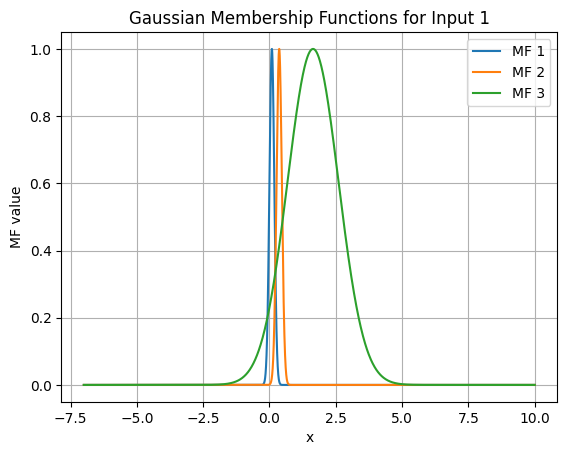

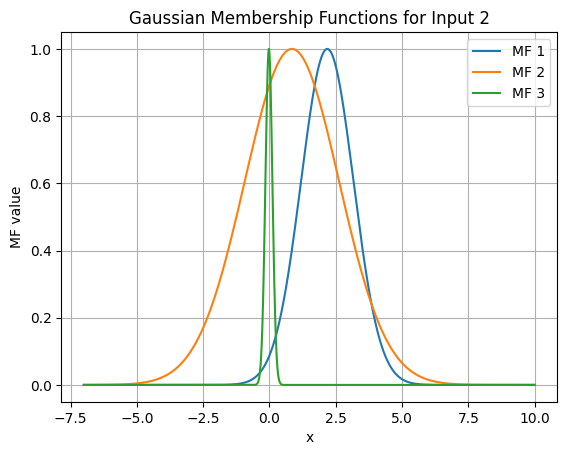

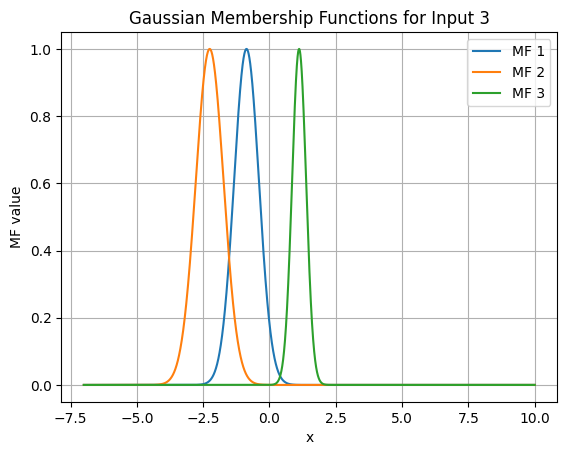

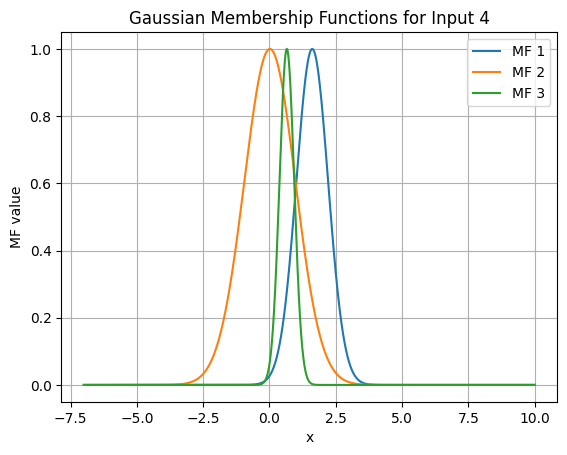

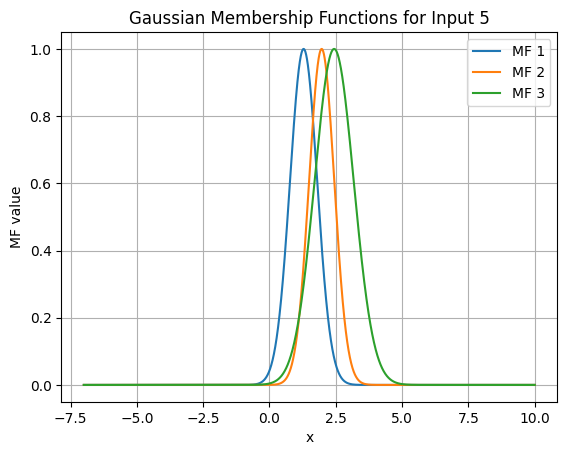

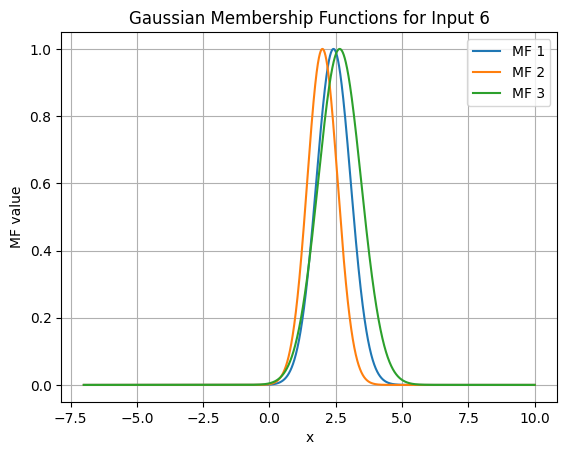

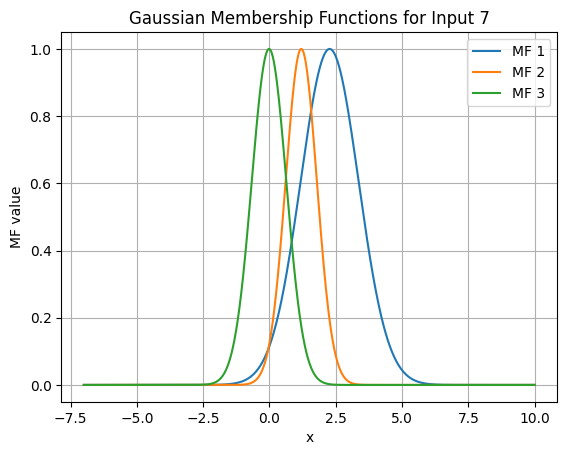

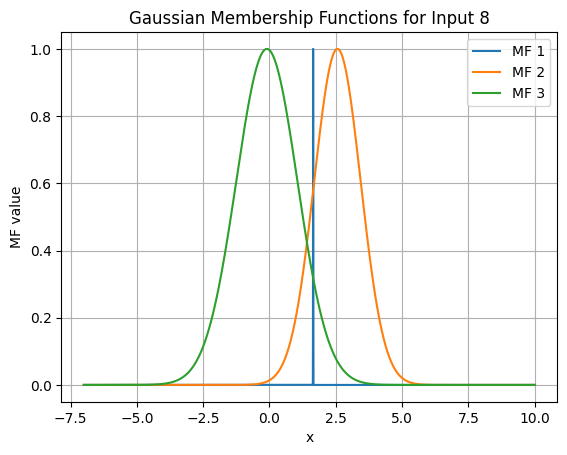

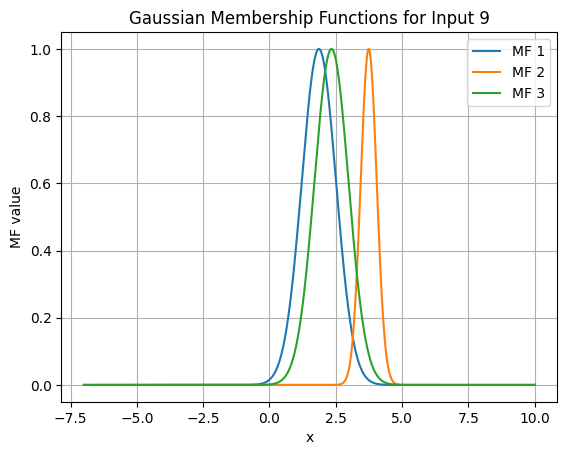

In [13]:
model_anfis.plot_gaussian_with_values(linspace=torch.linspace(-7,10,999999))

### Wniosek
Również w tym przypadku ANFIS okazał się lepszy. Natomiast rezultaty obu modeli nie są zbyt dobre. 

# Iris - klasyfikacja

Modelu ANFIS możemy użyć także w zadaniu klasyfikacyjnym. 

Zestaw danych Iris został użyty w klasycznym artykule R.A. Fishera z 1936 roku pt. "The Use of Multiple Measurements in Taxonomic Problems" i można go również znaleźć w UCI Machine Learning Repository.

Zestaw zawiera próbki trzech gatunków irysów, po 50 próbek dla każdego gatunku, oraz pewne właściwości każdej rośliny. Jeden z gatunków jest liniowo separowalny od pozostałych dwóch, natomiast pozostałe dwa nie są liniowo separowalne między sobą.

Kolumny w tym zestawie danych to:

Id – identyfikator próbki <br>
SepalLengthCm – długość działki kielicha w centymetrach <br>
SepalWidthCm – szerokość działki kielicha w centymetrach <br>
PetalLengthCm – długość płatka w centymetrach <br>
PetalWidthCm – szerokość płatka w centymetrach <br>
Species – gatunek irysa <br>
https://archive.ics.uci.edu/dataset/53/iris

In [17]:
iris = load_iris()
X = iris.data
y = iris.target  # Already encoded as integers 0, 1, 2
X, y

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

## Porównanie modeli
Ładujemy dane testowe zapisane w trakcie trenowania modelu

In [18]:
print("Loading test dataset")
data = pd.read_csv("test_datasets/iris_test_dataset.csv", header=None)
data

Loading test dataset


,0,1,2,3,4
0,-1.018271,0.826864,-1.277618,-1.093579,0
1,0.698556,-0.551926,1.037806,1.189507,2
2,2.538014,1.746057,1.500891,1.055207,2
3,1.066448,-0.092330,0.806264,1.458105,2
4,1.066448,-1.241321,1.153577,0.786609,2
5,1.189078,0.367267,1.211463,1.458105,2
6,-1.263532,-0.092330,-1.393389,-1.227878,0
7,-1.263532,0.137469,-1.277618,-1.362177,0
8,-1.508793,1.286460,-1.624931,-1.362177,0
9,-0.159858,3.124847,-1.335503,-1.093579,0


In [19]:
# Split features and target
X = data.iloc[:, :-1].values  # All columns except the last one as features
y = data.iloc[:, -1].values   # The last column as the target

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

### MLP

In [31]:
model_mlp = MLP(input_dim=X_tensor.shape[1])
# Path to the .pth file
weights_path = "models/iris_best_mlp_model.pth"

# Load the state dictionary from the .pth file
state_dict = torch.load(weights_path, weights_only=True)

# Load weights into the model
model_mlp.load_state_dict(state_dict)

# Set the model to evaluation mode 
model_mlp.eval()

# Convert true labels and predictions to numpy arrays
y_test = y_tensor.flatten().numpy()  # Ensure y_test is a 1D array
y_pred = model_mlp(X_tensor).detach().numpy()# Get predicted logits
# Round the predictions to the nearest integer to map them to class labels
y_pred= np.round(y_pred).astype(int)
# Make sure the class labels are within the valid range (assuming 0, 1, 2 are valid labels for Iris dataset)
y_pred = np.clip(y_pred, 0, 2) 

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['Setosa', 'Versicolor', 'Virginica'])
print("Classification Report:")
print(class_report)


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Confusion Matrix:
[[8 0 0]
 [0 2 0]
 [0 0 6]]
Classification Report:
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00         8
  Versicolor       1.00      1.00      1.00         2
   Virginica       1.00      1.00      1.00         6

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



### ANFIS

In [30]:
model_anfis = ANFIS(
    number_of_features=X_tensor.shape[1],
    number_of_membership_functions=3
)
# Path to the .pth file
weights_path = "models/iris_best_anfis_model.pth"

# Load the state dictionary from the .pth file
state_dict = torch.load(weights_path, weights_only=True)

# Load weights into the model
model_anfis.load_state_dict(state_dict)

# Set the model to evaluation mode 
model_anfis.eval()

# Convert true labels and predictions to numpy arrays
y_test = y_tensor.flatten().numpy()  # Ensure y_test is a 1D array
y_pred = model_anfis(X_tensor).detach().numpy()# Get predicted logits
# Round the predictions to the nearest integer to map them to class labels
y_pred= np.round(y_pred).astype(int)
# Make sure the class labels are within the valid range (assuming 0, 1, 2 are valid labels for Iris dataset)
y_pred = np.clip(y_pred, 0, 2) 

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['Setosa', 'Versicolor', 'Virginica'])
print("Classification Report:")
print(class_report)


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Confusion Matrix:
[[8 0 0]
 [0 2 0]
 [0 0 6]]
Classification Report:
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00         8
  Versicolor       1.00      1.00      1.00         2
   Virginica       1.00      1.00      1.00         6

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



Możemy zwizualizować **funkcje przynależności** dla każdego wejścia

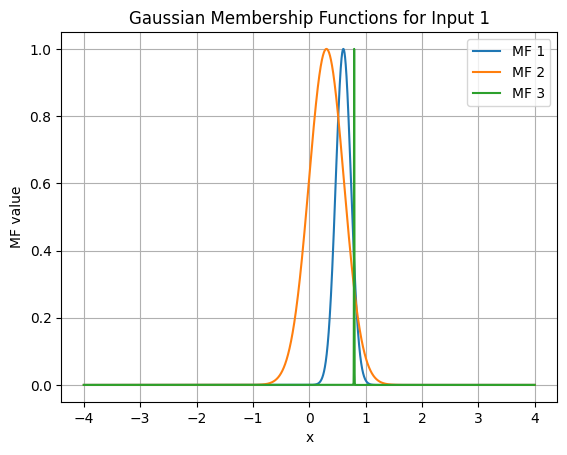

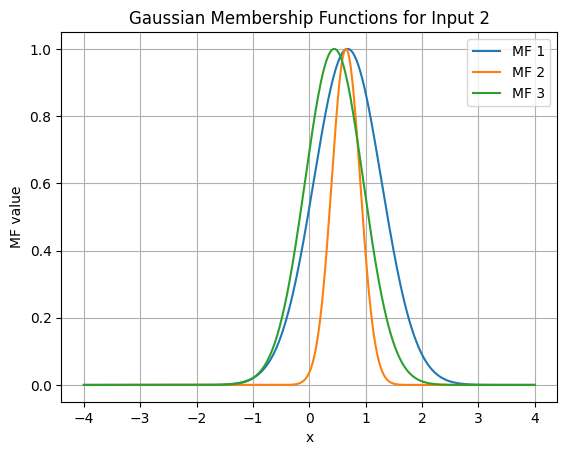

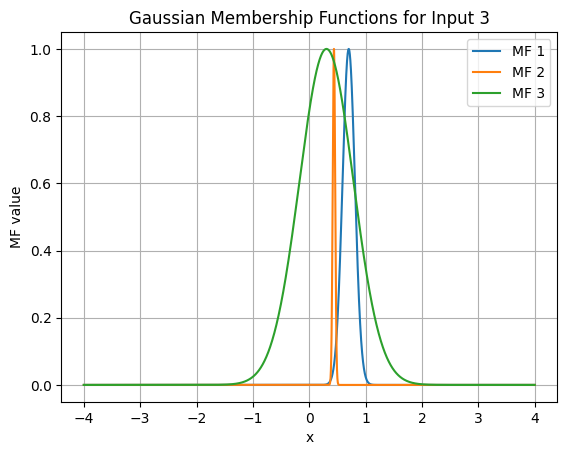

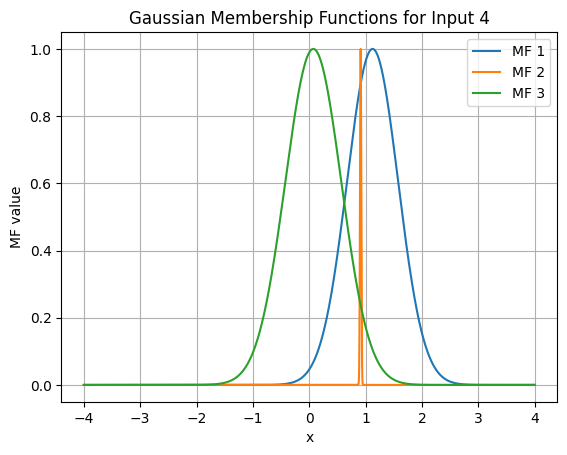

In [33]:
model_anfis.plot_gaussian_with_values(linspace=torch.linspace(-4,4,999999))

### Wnioski
Oba modele uzyskały 100% dokładności w tym zadaniu. Przykład ten pokazuje, że ANFIS oraz inne modele regresyjne mogą zostać użyte również do klasyfikacji. 